In [8]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [10]:
root = '/Users/n.arai'

In [12]:
torchvision.datasets.FashionMNIST(root, train=True, transform=None, download=False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /Users/n.arai/FashionMNIST/raw/train-images-idx3-ubyte.gz to /Users/n.arai/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /Users/n.arai/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /Users/n.arai/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /Users/n.arai/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /Users/n.arai/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /Users/n.arai/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/n.arai/FashionMNIST/raw



Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /Users/n.arai
    Split: Train
    StandardTransform
Transform: True

In [14]:
data_transform = transforms.ToTensor()

train_dataset = datasets.FashionMNIST(root="dataset", train=True, transform=data_transform, download=True)

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,shuffle=True)

test_dataset = datasets.FashionMNIST(root="datasets", train=False, transform=data_transform,download=True)

test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32,shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to datasets/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to datasets/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to datasets/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/FashionMNIST/raw



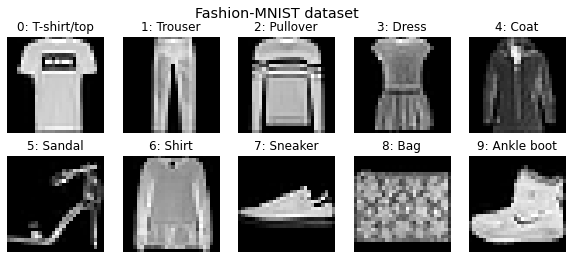

In [26]:
class_ids, sample_indices = np.unique(train_dataset.targets, return_index=True)

fig = plt.figure(figsize=(10, 4))
fig.suptitle("Fashion-MNIST dataset", fontsize="x-large")

for i in class_ids:
    img = train_dataset.data[sample_indices[i]]
    class_name = train_dataset.classes[i]

    ax = fig.add_subplot(2, 5, i + 1)
    ax.set_title(f"{i}: {class_name}")
    ax.set_axis_off()
    ax.imshow(img, cmap="gray")

plt.show()

In [41]:
#クラスに対して画像が何枚あるか可視化->偏りなし
counts = np.bincount(train_dataset.targets)
for i, (count, name) in enumerate(zip(counts, train_dataset.classes)):
    print("{0:25} {1:3}".format(name, count), end='     ')
    if (i + 1) % 3 == 0:
        print()

T-shirt/top               6000     Trouser                   6000     Pullover                  6000     
Dress                     6000     Coat                      6000     Sandal                    6000     
Shirt                     6000     Sneaker                   6000     Bag                       6000     
Ankle boot                6000     

In [58]:
class FashionMNIST_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(128, 10),
        nn.LogSoftmax(dim=1))
        
    def forward(self, x):
        x  = self.features(x)
        x =  torch.flatten(x, 1)
        x = self.classifier(x)
            
        return x

In [59]:
nll_loss = nn.NLLLoss()

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FashionMNIST_Model().to(device)

In [61]:
optim = torch.optim.Adam(model.parameters())

In [80]:
def train(model, device, data_loader, optim):
    model.train()
    
    total_loss = 0
    total_correct = 0
    for data, target in data_loader:
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        
        loss = nll_loss(output, target)
        total_loss += float(loss)
        
        optim.zero_grad()
        loss.backward()
        
        optim.step()
        
        pred_target = output.argmax(dim=1)
        
        total_correct += int((pred_target == target).sum())
        
    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = total_correct / len(data_loader.dataset)
    
    return avg_loss, accuracy

In [83]:
def test(model, device, data_loader):
    model.eval()
    
    with torch.no_grad():
        total_loss = 0
        total_correct = 0
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            
            loss = nll_loss(output, target)
            total_loss += float(loss)
            
            pred_target = output.argmax(dim=1)
            
            total_correct += int((pred_target == target).sum())
            
            avg_loss = total_loss / len(data_loader.dataset)
            accuracy = total_correct / len(data_loader.dataset)
            
    return avg_loss, accuracy

In [85]:
n_epochs = 50

history = defaultdict(list)
for epoch in range(n_epochs):
    train_loss, train_accuracy = train(model, device, train_data_loader, optim)
    history["train_loss"].append(train_loss)
    history["train_accuracy"].append(train_accuracy)
    
    test_loss, test_accuracy = test(model, device, test_data_loader)
    history["test_loss"].append(test_loss)
    history["test_accuracy"].append(test_accuracy)
    
    print(
        f"epoch {epoch + 1} "
        f"[train] loss: {train_loss:.6f}, accuracy: {train_accuracy:.0%} "
        f"[test] loss: {test_loss:.6f}, accuracy: {test_accuracy:.0%}"
    )

epoch 1 [train] loss: 0.010725, accuracy: 87% [test] loss: 0.008836, accuracy: 90%
epoch 2 [train] loss: 0.009902, accuracy: 88% [test] loss: 0.008570, accuracy: 90%
epoch 3 [train] loss: 0.009328, accuracy: 89% [test] loss: 0.008276, accuracy: 90%
epoch 4 [train] loss: 0.008797, accuracy: 90% [test] loss: 0.008328, accuracy: 90%
epoch 5 [train] loss: 0.008518, accuracy: 90% [test] loss: 0.007557, accuracy: 91%
epoch 6 [train] loss: 0.008092, accuracy: 91% [test] loss: 0.007461, accuracy: 91%
epoch 7 [train] loss: 0.007977, accuracy: 91% [test] loss: 0.007265, accuracy: 91%
epoch 8 [train] loss: 0.007676, accuracy: 91% [test] loss: 0.007208, accuracy: 92%
epoch 9 [train] loss: 0.007517, accuracy: 91% [test] loss: 0.007829, accuracy: 91%
epoch 10 [train] loss: 0.007361, accuracy: 91% [test] loss: 0.007224, accuracy: 92%
epoch 11 [train] loss: 0.007291, accuracy: 91% [test] loss: 0.007014, accuracy: 92%
epoch 12 [train] loss: 0.007145, accuracy: 92% [test] loss: 0.007264, accuracy: 92%
e